In [1]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()
## This is for progress bars only ... not sure what `%%capture` does.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
# from sklearn.neighbors import KernelDensity
import colorcet as cc
from scipy.ndimage import label, generate_binary_structure

In [3]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val


def get_labels(da, crit):
    assert "time" in da.dims
    assert "lat" in da.dims
    assert "lon" in da.dims
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    labeled_arrays = []
    n_features = []
    for t in range(mask.shape[0]):
        la, nf = label(mask[t, :, :], structure=generate_binary_structure(2, 2))
        la = xr.DataArray(
            la, dims=("lat", "lon"), coords={"lat": da.lat, "lon": da.lon}
        )
        labeled_arrays.append(la)
        n_features.append(nf)
    nfarr = xr.DataArray(np.array(n_features), dims="time", coords={"time": da.time})
    lbarr = xr.concat(labeled_arrays, dim="time")
    lbarr = lbarr.assign_coords({"time": da.time})
    return lbarr, nfarr


def get_labels3d(da, crit):
    """Label events through time."""
    assert "time" in da.dims
    assert "lat" in da.dims
    assert "lon" in da.dims
    mask = np.where(da >= crit, 1, 0)
    assert len(mask.shape) == 3  # has to be time,lat,lon
    la, nf = label(mask, structure=generate_binary_structure(3, 2))
    la = xr.DataArray(la, dims=da.dims, coords=da.coords)
    # nf is just an integer
    return la, nf


def pr_labeler(p, pcrit, track=False, latitude=None):
    """This method just controls the flow to the different labeling functions."""
    if latitude is not None:
        pw = p.sel(lat=latitude)
    else:
        pw = p
    if track:
        labels, nfeatures = get_labels3d(pw, pcrit)
    else:
        labels, nfeatures = get_labels(pw, pcrit)
    return labels, nfeatures


def get_events_per_time(larr):
    return [len(np.unique(larr[t,:,:]))-1 for t in range(larr.shape[0])]


def get_simple_size(larr):
    """larr is set of labeled arrays. 
    Count how many points have each label, 
    return average and standard deviation 
    of that count for each time."""
    a_size = []
    a_sizestd = []
    for i, tim in enumerate(larr["time"]):
        ctr = np.bincount(larr[i, :, :].values.flatten())
        a_size.append(ctr[1::].mean())
        a_sizestd.append(ctr[1::].std())
    a_size = np.array(a_size)
    a_sizestd = np.array(a_sizestd)
    return a_size, a_sizestd


def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [4]:
# We should account for wrapping around longitude
# * https://stackoverflow.com/questions/55953353/how-to-specify-a-periodic-connection-for-features-of-scipy-ndimage-label
# if this is fast enough, it will also provide a vector of features per time

# Performance notes:
# This is potentially very slow.
# Naive approach would loop over all times and all latitudes, which is already a bit slow.
# Pretty easy to reduce that by checking whether there are any values to check. 
# Even reducing the loops to what I think is minimal, it is slow if we 
# try to update the array with boolean indexing for each identified wrapped feature.
# For example, doing new_labels[new_labels == new_labels[t, y, 0]] = older_feature
# I'm not sure exactly why this is so slow.
# MUCH, MUCH faster is to make a list of changes that need to be made.
# Here, `transformer` is the list, just a dictionary with keys being the feature to change
# and values being the corrected value. Creating this dictionary is very fast.
# Then a separate step loops through the dictionary and actually does the change,
# for example using labels = np.where(labels==dictkey, dictvalue, labels)
# In my test case, my initial attempts were going to run for ~2.5 hours,
# but in the transformer/where steps, that was reduced to ~5 minutes.

def wrap_events(input_labels):
    if isinstance(input_labels, xr.DataArray):
        labels = input_labels.values
    else:
        labels = input_labels
    new_labels = labels.copy()
    transformer = dict()
    for t in tqdm(range(new_labels.shape[0])):
        if np.all(new_labels[t,:,0] == 0) or np.all(new_labels[t,:,-1] == 0):
            continue  # no reason to check if no events on edges
        check_lats = np.intersect1d(np.nonzero(new_labels[t, :, 0]), np.nonzero(new_labels[t, :, -1]))
        if len(check_lats) == 0:
            continue
        for y in check_lats:
            if new_labels[t,y,0] != new_labels[t,y,-1]:
                # now we know that [t, y, 0] and [t, y, -1] should be part of same feature, and the label should be the smaller of the two
                older_feature = np.min([new_labels[t, y, 0], new_labels[t, y, -1]])
                if new_labels[t, y, 0] < new_labels[t, y, -1]:
                    transformer[new_labels[t, y, -1]] = older_feature
                else:
                    transformer[new_labels[t, y, 0]] = older_feature
    return transformer


def event_wrapper(labels, transformer_dict):
    if isinstance(labels, xr.DataArray):
        lll = labels.values
    else:
        lll = labels
    new_labels = lll.copy()
    for k in tqdm(transformer_dict):
        new_labels = np.where(new_labels==k, transformer_dict[k], new_labels)
    if isinstance(labels, xr.DataArray):
        new_labels = xr.DataArray(new_labels, dims=labels.dims, coords=labels.coords)
    return new_labels


def get_initial_tindex(labels, ev):
    if isinstance(labels, np.ndarray):
        labv = labels
    else:
        labv = labels.values  # converts to numpy array
    for t in range(labv.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if ev in present_events:
            return t
    return None




In [5]:
def pr_label_workflow(
    model,
    exp0,
    exp1,
    mem0,
    mem1,
    remove_land=False,
    label="2d",
    latitude=None,
    lon_wrap=True,
):
    """Loads daily precipitation data for 2 simulations, 
    calculates the 99th percentile of tropical precipitation,
    detects precipitation features.
    Options:
        - remove_land : loads land fraction for the simulation and removes land.
        - label : if '2d' do detection on time slices independently, 
                  if '3d' do detection in time (cheap tracking).
        - latitude : use a subset of latitudes, typically provide a slice object.
        - lon_wrap : if true run the code to connect events across longitude boundary.
        
    Commented out the `get_simple_size` lines... do those afterward.
    
    No longer return number of features. Depends on whether tracking or not, also changes
    if lon_wrap is True, so need to re-calculate either way. 
    """
    m0 = quick_load_var(data_loc, "pr", "day", model, exp0, mem0)
    m0 *= 86400.0  # unit conversion
    if remove_land:
        land0 = quick_load_var(data_loc, "sftlf", "fx", model, exp0, mem0)
        m0 = m0.where(land0 <= 0)
    m0_threshold = get_tropics_quantiles(m0, q=0.99)

    if label == "2d":
        track = False
    elif label == "3d":
        track = True

    m0_labels, m0_nfeatures = pr_labeler(
        m0, m0_threshold, track=track, latitude=latitude
    )

    m1 = quick_load_var(data_loc, "pr", "day", model, exp1, mem1)
    m1 *= 86400.0  # unit conversion
    if remove_land:
        land1 = quick_load_var(data_loc, "sftlf", "fx", model, exp1, mem1)
        m1 = m1.where(land1 <= 0)
    m1_threshold = get_tropics_quantiles(m1, q=0.99)
    m1_labels, m1_nfeatures = pr_labeler(
        m1, m1_threshold, track=track, latitude=latitude
    )

    if lon_wrap:
        m0_transformer = wrap_events(m0_labels)
        m1_transformer = wrap_events(m1_labels)
        m0_labels = event_wrapper(m0_labels, m0_transformer)
        m1_labels = event_wrapper(m1_labels, m1_transformer)

    # m0_size, m0_sizestd = get_simple_size(m0_labels)
    # m1_size, m1_sizestd = get_simple_size(m1_labels)
    return m0_labels, m1_labels

In [6]:
def get_duration(lab):
    """Returns a dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev] += 1 # continuing
                else:
                    dur[ev] = 1 # new event
    return dur

In [7]:
def get_duration_and_size(lab, rettype='df'):
    """Returns either a Pandas DataFrame (default) or dictionary with keys that are event labels and values that are duration (days)."""
    dur = dict()
    # put eventID as key, values are dict: {duration: D, size: [s_0, ..., s_d]}
    if isinstance(lab, np.ndarray):
        labv = lab
    else:
        labv = lab.values  # converts to numpy array
    for t in range(lab.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if len(present_events) > 0:
            for ev in present_events:
                if ev in dur:
                    dur[ev]['duration'] += 1 # continuing
                    dur[ev]['size'].append(np.count_nonzero(tmp==ev))
                else:
                    dur[ev] = dict() # new event
                    dur[ev]['duration'] = 1
                    dur[ev]['size'] = [np.count_nonzero(tmp==ev)]
    if rettype == 'df':
        # convert to dataFrame
        df = pd.DataFrame.from_dict(dur, orient ='index')
        # compute average size and include as a column
        asiz = []
        msiz = []
        for s in df['size']:
            asiz.append(np.mean(s))
            msiz.append(np.max(s))
        df['AvgSiz'] = asiz
        df['MaxSiz'] = msiz
        # get distribution of average size
        return df
    else:
        return dur  # AvgSiz and MaxSiz not included in output dict.

In [8]:
def summarize_events(labels, mstr, estr):
    X = get_events_per_time(labels)
    Y = get_duration_and_size(labels)  # Y is a pandas DF with columns: duration, size, AvgSiz, MaxSiz
    tot_number_events = len(Y)
#     dur = []
#     avgsiz = []
#     mxsiz = []
#     for ev in Y:
#         dur.append(Y[ev]["duration"])
#         avgsiz.append(np.mean(Y[ev]["size"]))
#         mxsiz.append(np.max(Y[ev]["size"]))
    avg_duration = np.mean(Y['duration'])
    std_duration = np.std(Y['duration'])
    avg_size = np.mean(Y['AvgSiz'])
    std_size = np.std(Y['AvgSiz'])
    avg_mx_size = np.mean(Y['MaxSiz'])
    std_mx_size = np.std(Y['MaxSiz'])
    print(
        f"{mstr} {estr}: [N_events] = {np.mean(X):.2f} ± {np.std(X):.2f}, Ntot: {tot_number_events:.2f}, [D] = {avg_duration:.2f} ± {std_duration:.2f}, [S] = {avg_size:.2f} ± {std_size:.2f}, [Smx] = {avg_mx_size:.2f} ± {std_mx_size:.2f}"
    )

In [9]:
#
# Make a map of event frequency & change
#

import palettable     # more colortables!
import cartopy
import cartopy.crs as ccrs


def get_simulation_nyears(ds):
    return len(set(ds['time.year'].values))


def get_event_freq(cntl_labels):
    cntl_labels_spatial_tot = np.where(cntl_labels>0,1,0).sum(axis=0)
    cntl_labels_spatial_tot = xr.DataArray(cntl_labels_spatial_tot, dims=("lat","lon"), coords={"lat":cntl_labels['lat'], "lon":cntl_labels['lon']})
    # normalize by number of years:
    cntl_frq = cntl_labels_spatial_tot/get_simulation_nyears(cntl_labels)
    return(cntl_frq)


def map_event_freq(wks, f1, f2, coastlines=True, title1=None, title2=None):
    """
    wks : full path for output plot
    f1  : frequency of events in 'control'
    f2  : frequency of events in 'experiment'
    coastlines: bool to draw coastlines and fill continents
    """
    d_frq = f2 - f1
    cm = palettable.scientific.sequential.Acton_20_r.mpl_colormap
    lons, lats = np.meshgrid(f1['lon'], f1['lat'])
    fig, ax = plt.subplots(figsize=(10,5), nrows=3, subplot_kw={"projection":ccrs.PlateCarree()})
    img0 = ax[0].pcolormesh(lons, lats, f1, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
    img1 = ax[1].pcolormesh(lons, lats, f2, transform=ccrs.PlateCarree(), cmap=cm, vmin=0, vmax=35, rasterized=True)
    n = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
    cmdif =  palettable.lightbartlein.diverging.BrownBlue10_3.mpl_colormap
    img2 = ax[2].pcolormesh(lons, lats, d_frq, transform=ccrs.PlateCarree(), cmap=cmdif, norm=n, rasterized=True)
    cb0 = fig.colorbar(img1, ax=ax[[0,1]].ravel(), shrink=0.5)
    cb = fig.colorbar(img2, ax=ax[2])

    ax[0].set_title(title1, loc='left')
    ax[1].set_title(title2, loc='left')
    ax[2].set_title("Difference", loc='left')
    if coastlines:
        ax[0].coastlines()
        ax[1].coastlines()
        ax[2].coastlines()
        ax[0].add_feature(cartopy.feature.LAND, zorder=10)
        ax[1].add_feature(cartopy.feature.LAND, zorder=10)
        ax[2].add_feature(cartopy.feature.LAND, zorder=10)
    fig.savefig(wks, dpi=300, bbox_inches='tight')

For each simulation, we take the daily mean precipitaiton, calculate the 99th percentile of the precipitation in the tropical ocean, and then label each precipitating event for each day.

The next step is to track the events through time, as in Pendergrass. We start at the second day, and for each event identified we ask:
- does the event share any locations with events in the prior day. 
    + if YES, then we have to check whether it touches more than 1:
        - if NO, then we assign the Event ID number of the points in the event to the ID number of the event from the previous day.
        - if YES, then this is a merger, and the points in this event are assigned the mininum Event ID of the prior events. This assumes that we prefer to keep long-lived events.
    + if YES, we also need to check whether more than one identified event in present day touches the same event in prior day.
        - if YES this is a splitting event. If one of the present events is larger, that one should persist the prior Event ID. Otherwise choose arbitrarily which one persists and which one gets a new ID.
    + if NO, this is a new event and gets a new Event ID.

In [10]:
DRIVE = "Jedha"
data_loc = f"/Volumes/{DRIVE}/CMIP6"

In [17]:
%%time
# list of simulations:
# There are more ensemble members for 'amip'

# tup1 = ("IPSL-CM6A-LR", "amip", "r1i1p1f1")
# tup2 = ("IPSL-CM6A-LR", "amip-lwoff", "r1i1p1f1")
# tup1 = ("IPSL-CM6A-LR", "aqua-control", "r1i1p1f1")
# tup2 = ("IPSL-CM6A-LR", "aqua-control-lwoff", "r1i1p1f1")

# tup1 = ("CESM2", "amip", "r1i1p1f1")
# tup2 = ("CESM2", "amip-lwoff", "r1i1p1f1")
# tup1 = ("CESM2", "aqua-control", "r1i1p1f1")
# tup2 = ("CESM2", "aqua-control-lwoff", "r1i1p1f1")

# tup1 = ("CNRM-CM6-1", "amip", "r1i1p1f2")
# tup2 = ("CNRM-CM6-1", "amip-lwoff", "r1i1p1f2")

# tup1 = ("CNRM-CM6-1", "aqua-control", "r1i1p1f2")
# tup2 = ("CNRM-CM6-1", "aqua-control-lwoff", "r1i1p1f2")

# tup1 = ("MRI-ESM2-0", "amip", "r1i1p1f1")
# tup2 = ("MRI-ESM2-0", "amip-lwoff", "r1i1p1f1")

# tup1 = ("HadGEM3-GC31-LL", "aqua-control", "r1i1p1f3")
# tup2 = ("HadGEM3-GC31-LL", "aqua-control-lwoff", "r1i1p1f3")

tup1 = ("HadGEM3-GC31-LL", "amip", "r1i1p1f3")
tup2 = ("HadGEM3-GC31-LL", "amip-lwoff", "r5i1p1f2")

# unpack the inputs:
mdl1, e1, r1 = tup1
mdl2, e2, r2 = tup2
# r = "r1i1p1f1"
# e1 = "aqua-control"
# e2 = "aqua-control-lwoff"
# e1 = "amip"
# e2 = "amip-lwoff"

if e1 == 'amip':
    rmlnd = True
elif 'aqua' in e1:
    rmlnd = False
else: 
    raise ValueError("Need to specify how to deal with land.")

if mdl1 != mdl2:
    raise ValueError("We are not set up to compare models.")

# gets the labels with temporal tracking / tropical values (30S-30N) 
pr0_labels, pr1_labels = pr_label_workflow(mdl1, e1, e2, r1, r2, remove_land=rmlnd,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

summarize_events(pr0_labels, mdl1, e1)
summarize_events(pr1_labels, mdl2, e2)

Quantile value: 48.26662220001219
Quantile value: 40.30130249023432



HadGEM3-GC31-LL amip: [N_events] = 15.49 ± 3.61, Ntot: 112488.00, [D] = 1.79 ± 1.97, [S] = 2.52 ± 2.45, [Smx] = 3.32 ± 4.47
HadGEM3-GC31-LL amip-lwoff: [N_events] = 14.04 ± 3.34, Ntot: 101985.00, [D] = 1.78 ± 2.11, [S] = 2.78 ± 2.89, [Smx] = 3.65 ± 5.19
CPU times: user 40.2 s, sys: 4.96 s, total: 45.1 s
Wall time: 48.3 s


In [18]:
%%time
# -- histogram of precipitation -- 
pr1 = quick_load_var(data_loc, 'pr', 'day', mdl1, e1, r1)
pr1 *= 86400.0  # unit conversion
if rmlnd:
    land0 = quick_load_var(data_loc, "sftlf", "fx", mdl1, e1, r1)
    pr1 = pr1.where(land0 <= 0)
# only tropics:
pr1 = pr1.sel(lat=slice(-30,30))
hpr1, hpredge1 = np.histogram(pr1.values, bins=np.arange(-10., 210., 10), density=True)
hpr1ctr = hpredge1[1:] + np.diff(hpredge1)
hpr1frq = hpr1*np.diff(hpredge1)


pr2 = quick_load_var(data_loc, 'pr', 'day', mdl2, e2, r2)
pr2 *= 86400.0  # unit conversion
if False:
    land0 = quick_load_var(data_loc, "sftlf", "fx", mdl2, e2, r2)
    pr2 = pr2.where(land0 <= 0)
# only tropics:
pr2 = pr2.sel(lat=slice(-30,30))
hpr2, hpredge2 = np.histogram(pr2.values, bins=np.arange(-10., 210., 10), density=True)
hpr2ctr = hpredge2[1:] + np.diff(hpredge2)
hpr2frq = hpr2*np.diff(hpredge2)

# -- duration and size -- 
dursiz0 = get_duration_and_size(pr0_labels)
dursiz1 = get_duration_and_size(pr1_labels)


hsiz0, sizedge0 = np.histogram(dursiz0['AvgSiz'], bins=np.arange(0, 50, 1), density=True)
sizbctr0 = sizedge0[1:] + np.diff(sizedge0)
hsizfrq0 = hsiz0 * np.diff(sizedge0)

hsiz1, sizedge1 = np.histogram(dursiz1['AvgSiz'], bins=np.arange(0, 50, 1), density=True)
sizbctr1 = sizedge1[1:] + np.diff(sizedge1)
hsizfrq1 = hsiz1 * np.diff(sizedge1)

# -- event duration --
hdur0, duredge0 = np.histogram(dursiz0['duration'], bins=np.arange(.5, 50.5, 1), density=True)
durfrq0 = hdur0 * np.diff(duredge0)
durctr0 = duredge0[1:] + np.diff(duredge0)

hdur1, duredge1 = np.histogram(dursiz1['duration'], bins=np.arange(.5, 50.5, 1), density=True)
durfrq1 = hdur1 * np.diff(duredge1)
durctr1 = duredge1[1:] + np.diff(duredge1)


CPU times: user 31.3 s, sys: 2.64 s, total: 34 s
Wall time: 35.7 s


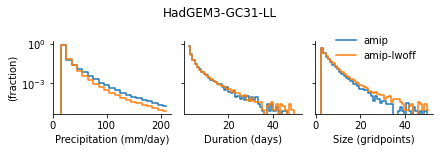

In [19]:

fig, ax = plt.subplots(figsize=(6,2), ncols=3, constrained_layout=True, sharey=True)
ax[0].step(hpr1ctr, hpr1frq, where='mid')
ax[0].step(hpr2ctr, hpr2frq, where='mid')
ax[0].set_xlabel("Precipitation (mm/day)")
ax[0].set_ylabel("(fraction)")

ax[2].step(sizbctr0, hsizfrq0, where='mid', label=e1)
ax[2].step(sizbctr1, hsizfrq1, where='mid', label=e2)
ax[2].set_xlabel("Size (gridpoints)")

ax[1].step(durctr0, durfrq0, where='mid', label=e1)
ax[1].step(durctr1, durfrq1, where='mid', label=e2)
ax[1].set_xlabel("Duration (days)")

for a in ax:
    a.semilogy()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.patch.set_alpha(0.)

ax[2].legend(frameon=False, loc='upper left', bbox_to_anchor= (.1, 1.2),)
fig.suptitle(mdl1)
fig.savefig(f"/Users/brianpm/Desktop/tropical_ocean_extreme_precip_distribution_{mdl1}_{e1}_{e2}.png", dpi=300, bbox_inches='tight')

CPU times: user 3.59 s, sys: 518 ms, total: 4.11 s
Wall time: 1.64 s


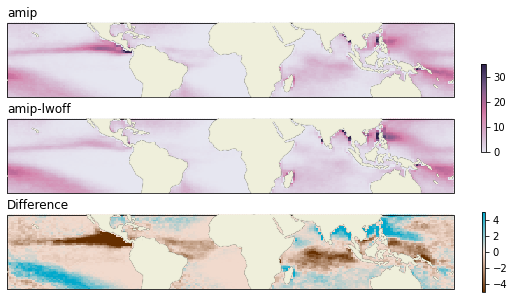

In [20]:
%%time
eventfreq0 = get_event_freq(pr0_labels)
eventfreq1 = get_event_freq(pr1_labels)
pname = f"/Users/brianpm/Desktop/{mdl1}_{e1}_{e2}_precip_event_frequency.png"
map_event_freq(pname, eventfreq0, eventfreq1, coastlines=rmlnd, title1=e1, title2=e2)

In [21]:
# Alternative question is how much of the rain is associated with strong events?
pr1_crit = get_tropics_quantiles(pr1, threshold=None, q=0.99)
pr2_crit = get_tropics_quantiles(pr2, q=0.99)

pr1_tot = pr1.sum(dim=("lat","lon"))
pr1_xsum = pr1.where(pr1 >= pr1_crit).sum(dim=("lat","lon"))
pr1_xcontrib = pr1_xsum / pr1_tot

pr2_tot = pr2.sum(dim=("lat","lon"))
pr2_xsum = pr2.where(pr2 >= pr2_crit).sum(dim=("lat","lon"))
pr2_xcontrib = pr2_xsum / pr2_tot

print(f"Average extreme contribution in control: {pr1_xcontrib.values.mean():.2f} \pm {pr1_xcontrib.values.std():.2f}, and in LWoff: {pr2_xcontrib.values.mean():.2f} \pm {pr2_xcontrib.values.std():.2f}")

Quantile value: 48.26662220001219
Quantile value: 37.095666236877264
Average extreme contribution in control: 0.17 \pm 0.05, and in LWoff: 0.14 \pm 0.04


In [22]:
#
# Save labeled events so as to enable easier filtering
#
pr0_labels.name = "precip_events"
pr1_labels.name = "precip_events"

if 'type' in pr0_labels.coords:
    if pr0_labels['type'].shape == ():
        pr0_labels = pr0_labels.drop('type')
        
if 'type' in pr1_labels.coords:
    if pr1_labels['type'].shape == ():
        pr1_labels = pr1_labels.drop('type')

oname0 = data_loc + "/" + "pr_events_"+"_".join(tup1)+".nc"
pr0_labels.to_netcdf(oname0)

oname1 = data_loc + "/" + "pr_events_"+"_".join(tup2)+".nc"
pr1_labels.to_netcdf(oname1)




## END

All code below here was from previous set of calculations, and can be reproduced with more generalized version above.

Quantile value: 41.60583381652839
Quantile value: 41.29681282043464



CNRM-CM6-1 aqua-control: [N_events] = 14.55 ± 3.15, Ntot: 33565.00, [D] = 1.58 ± 1.77, [S] = 4.36 ± 4.33, [Smx] = 5.54 ± 7.26
CNRM-CM6-1 aqua-control-lwoff: [N_events] = 12.74 ± 2.93, Ntot: 33339.00, [D] = 1.40 ± 1.21, [S] = 5.12 ± 5.96, [Smx] = 6.05 ± 8.43
CPU times: user 1min 48s, sys: 1min, total: 2min 48s
Wall time: 3min 4s


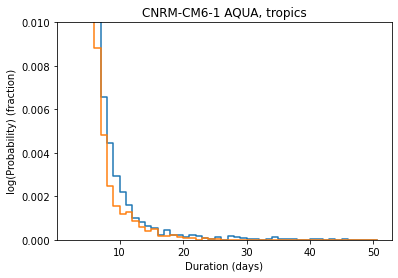

In [55]:
%%time
m = "CNRM-CM6-1"
r = "r1i1p1f2"
e1 = "aqua-control"
e2 = "aqua-control-lwoff"
eovr = "AQUA"

# gets the labels with temporal tracking / tropical values (30S-30N) 
cnrm0_labels, cnrm1_labels = pr_label_workflow(m, e1, e2, r, r, remove_land=False,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

# need duration
cnrm0_dur = get_duration(cnrm0_labels)
cnrm1_dur = get_duration(cnrm1_labels)

# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(cnrm0_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(cnrm1_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title(f"{m} {eovr}, tropics")

summarize_events(cnrm0_labels, m, e1)
summarize_events(cnrm1_labels, m, e2)



/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 36.46170570373533
Quantile value: 23.00404930114746



CESM2 aqua-control: [N_events] = 13.66 ± 3.37, Ntot: 29816.00, [D] = 1.67 ± 1.95, [S] = 6.73 ± 7.95, [Smx] = 8.91 ± 14.11
CESM2 aqua-control-lwoff: [N_events] = 17.30 ± 3.37, Ntot: 35752.00, [D] = 1.77 ± 1.63, [S] = 7.04 ± 7.40, [Smx] = 9.49 ± 12.45
CPU times: user 3min 57s, sys: 2min 17s, total: 6min 14s
Wall time: 6min 33s


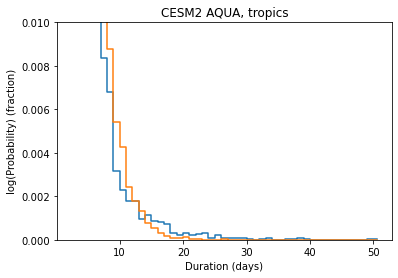

In [56]:
%%time
m = "CESM2"
r = "r1i1p1f1"
e1 = "aqua-control"
e2 = "aqua-control-lwoff"
eovr = "AQUA"

# gets the labels with temporal tracking / tropical values (30S-30N) 
cesm0_labels, cesm1_labels = pr_label_workflow(m, e1, e2, r, r, remove_land=False,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

# need duration
cesm0_dur = get_duration(cesm0_labels)
cesm1_dur = get_duration(cesm1_labels)

# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(cesm0_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(cesm1_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title(f"{m} {eovr}, tropics")

summarize_events(cesm0_labels, m, e1)
summarize_events(cesm1_labels, m, e2)




Quantile value: 47.04558120727552
Quantile value: 44.80594955444349



CNRM-CM6-1 amip: [N_events] = 12.08 ± 2.90, Ntot: 89594.00, [D] = 1.77 ± 2.06, [S] = 3.49 ± 3.59, [Smx] = 4.54 ± 6.21
CNRM-CM6-1 amip-lwoff: [N_events] = 12.48 ± 3.06, Ntot: 106396.00, [D] = 1.54 ± 2.03, [S] = 3.69 ± 3.81, [Smx] = 4.49 ± 5.85
CPU times: user 2min 28s, sys: 1min 20s, total: 3min 49s
Wall time: 4min 10s


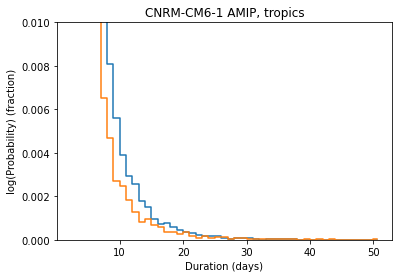

In [57]:
%%time
m = "CNRM-CM6-1"
r = "r1i1p1f2"
e1 = "amip"
e2 = "amip-lwoff"
eovr = "AMIP"

# gets the labels with temporal tracking / tropical values (30S-30N) 
cnrmA_labels, cnrmB_labels = pr_label_workflow(m, e1, e2, r, r, remove_land=True,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

# need duration
cnrmA_dur = get_duration(cnrmA_labels)
cnrmB_dur = get_duration(cnrmB_labels)

# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(cnrmA_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(cnrmB_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title(f"{m} {eovr}, tropics")

summarize_events(cnrmA_labels, m, e1)
summarize_events(cnrmB_labels, m, e2)

Quantile value: 36.43431427001923
Quantile value: 20.73476715087895



IPSL-CM6A-LR amip: [N_events] = 13.44 ± 3.51, Ntot: 79114.00, [D] = 2.42 ± 2.97, [S] = 2.19 ± 1.84, [Smx] = 2.99 ± 3.41
IPSL-CM6A-LR amip-lwoff: [N_events] = 12.61 ± 3.74, Ntot: 81788.00, [D] = 2.03 ± 2.18, [S] = 2.14 ± 2.30, [Smx] = 2.92 ± 4.28
CPU times: user 2min 29s, sys: 1min 9s, total: 3min 39s
Wall time: 3min 50s


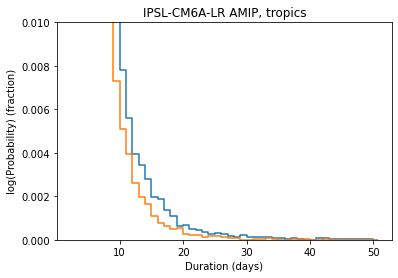

In [58]:
%%time
m = "IPSL-CM6A-LR"
r1 = "r1i1p1f1"
r2 = "r1i1p1f1"
e1 = "amip"
e2 = "amip-lwoff"
eovr = "AMIP"

# gets the labels with temporal tracking / tropical values (30S-30N) 
ipslA_labels, ipslB_labels = pr_label_workflow(m, e1, e2, r1, r2, remove_land=True,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

# need duration
ipslA_dur = get_duration(ipslA_labels)
ipslB_dur = get_duration(ipslB_labels)

# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(ipslA_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(ipslB_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title(f"{m} {eovr}, tropics")

summarize_events(ipslA_labels, m, e1)
summarize_events(ipslB_labels, m, e2)

/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 33.26182556152344


/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 30.823095607757466



CESM2 amip: [N_events] = 13.81 ± 3.28, Ntot: 175658.00, [D] = 1.87 ± 1.99, [S] = 5.45 ± 6.14, [Smx] = 7.54 ± 10.98
CESM2 amip-lwoff: [N_events] = 12.34 ± 3.15, Ntot: 91516.00, [D] = 1.77 ± 2.00, [S] = 5.88 ± 6.83, [Smx] = 7.97 ± 12.27
CPU times: user 4min 42s, sys: 2min 24s, total: 7min 7s
Wall time: 8min 6s


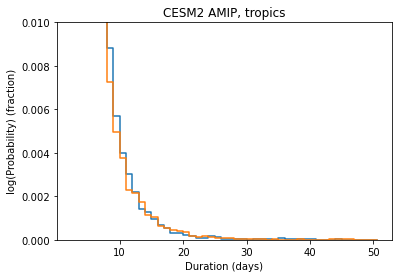

In [59]:
%%time
m = "CESM2"
r1 = "r1i1p1f1"
r2 = "r1i1p1f1"
e1 = "amip"
e2 = "amip-lwoff"
eovr = "AMIP"

# gets the labels with temporal tracking / tropical values (30S-30N) 
cesmA_labels, cesmB_labels = pr_label_workflow(m, e1, e2, r1, r2, remove_land=True,
    label="3d",
    latitude=slice(-30,30),
    lon_wrap=True)

# need duration
cesmA_dur = get_duration(cesmA_labels)
cesmB_dur = get_duration(cesmB_labels)

# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(cesmA_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(cesmB_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title(f"{m} {eovr}, tropics")

summarize_events(cesmA_labels, m, e1)
summarize_events(cesmB_labels, m, e2)

In [68]:
cnrm0_nf

36542

In [138]:
%%time
cnrm0_dur = get_duration(cnrm0_labels)

CPU times: user 253 ms, sys: 7.86 ms, total: 261 ms
Wall time: 328 ms


(0.0, 0.01)

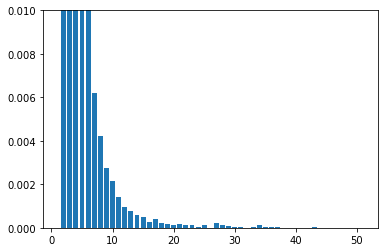

In [157]:
#
# Draw the histogram of duration
# 

fig, ax = plt.subplots()
h, bedge = np.histogram(list(cnrm0_dur.values()), bins=np.arange(.5, 50.5, .5), density=True)
bctr = bedge[1:] + np.diff(bedge)
ax.bar(bctr, h*np.diff(bedge))
ax.set_ylim([0., 0.01])

In [229]:
%%time
cnrm0_wrap_transformer = wrap_events(cnrm0_labels.values)
cnrm0_wrap_labels = cnrm0_labels.copy()
for k in tqdm(cnrm0_wrap_transformer):
    cnrm0_wrap_labels = np.where(cnrm0_wrap_labels==k, cnrm0_wrap_transformer[k], cnrm0_wrap_labels)
# updated duration estimates:
cnrm0_wrap_dur = get_duration(cnrm0_wrap_labels)

/Users/brianpm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



CPU times: user 357 ms, sys: 211 ms, total: 568 ms
Wall time: 585 ms


In [270]:
%%time
# moving to the second simulation
cnrm1_wrap_transformer = wrap_events(cnrm1_labels.values)
cnrm1_wrap_labels = event_wrapper(cnrm1_labels.values, cnrm1_wrap_transformer)
cnrm1_wrap_dur = get_duration(cnrm1_wrap_labels)


CPU times: user 2min 13s, sys: 1min 21s, total: 3min 35s
Wall time: 3min 41s


Text(0.5, 1.0, 'CNRM aqua, global')

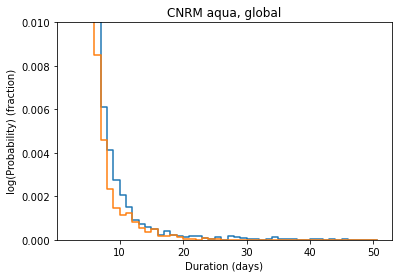

In [288]:
# Now we compare the histogram of event duration

fig, ax = plt.subplots()
h0, bedge0 = np.histogram(list(cnrm0_wrap_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr0 = bedge0[1:] + np.diff(bedge0)

h1, bedge1 = np.histogram(list(cnrm1_wrap_dur.values()), bins=np.arange(.5, 50.5, 1), density=True)
bctr1 = bedge1[1:] + np.diff(bedge1)

ax.step(bctr0, (h0*np.diff(bedge0)), where='mid')
ax.step(bctr1, (h1*np.diff(bedge1)), where='mid')
ax.set_ylim([0., 0.01])
ax.set_xlabel("Duration (days)")
ax.set_ylabel("log(Probability) (fraction)")
ax.set_title("CNRM aqua, global")

# TO DO: switch to tropics only
#        think about how to show this better ... exclude short events? Use a cumulative distribution?
# Apply to other models and experiments

# Also need to get "event size" in some way

In [285]:
bctr

array([ 1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,
        7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ,
       12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5,
       18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. ,
       23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5,
       29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. , 33.5, 34. ,
       34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5, 39. , 39.5,
       40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. ,
       45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5, 50. , 50.5])

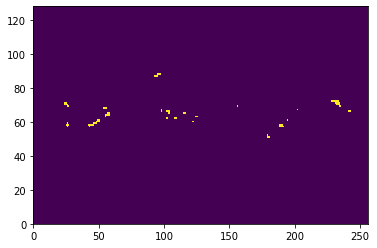

In [265]:


mxd = max(cnrm0_wrap_dur.values())
# for k in cnrm0_wrap_dur:
#     if cnrm0_wrap_dur[k] == mxd:
#         print(k)

mxd_event_init = get_initial_tindex(cnrm0_wrap_labels, 15494)

plt.pcolormesh(cnrm0_wrap_labels[mxd_event_init,:,:])

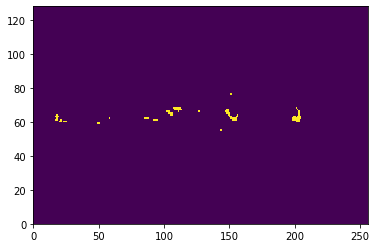

In [268]:
#
# Now that we have events identified and duration estimated -- need average number of events per day
#

In [51]:
%%time
cesm0_labels, cesm1_labels = full_workflow("CESM2", "aqua-control", "aqua-control-lwoff", "r1i1p1f1", "r1i1p1f1")

/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 36.46170570373533
Quantile value: 23.00404930114746
CONTROL: avg # = 18.06463982470556, std = 3.6107035637076463; avg size (gridpoints): 11.736600365345765
LWOFF: avg # = 22.85456039441249, std = 4.128641220344849; avg size (gridpoints): 11.175506144349514
(tropics) CONTROL: avg # = 16.545330046562587, std = 3.4087569844351773; avg size (gridpoints): 11.575559843815972
(tropics) LWOFF: avg # = 19.082717063818134, std = 3.6921014483762313; avg size (gridpoints): 9.805762126246387
CPU times: user 42.6 s, sys: 6.55 s, total: 49.1 s
Wall time: 54.7 s


In [54]:
%%time
cesmA_labels, cesmB_labels = full_workflow("CESM2", "amip", "amip-lwoff", "r1i1p1f1", "r1i1p1f1", remove_land=True)

/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 33.26182556152344


/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


Quantile value: 30.823095607757466
CONTROL: avg # = 20.45629267470286, std = 3.9907070648153455; avg size (gridpoints): 9.49132693965473
LWOFF: avg # = 17.933034015676128, std = 3.885558207687537; avg size (gridpoints): 10.2834673130478
(tropics) CONTROL: avg # = 15.372292000337183, std = 3.5114277663532656; avg size (gridpoints): 8.747929064341013
(tropics) LWOFF: avg # = 13.621337797732288, std = 3.38723882708889; avg size (gridpoints): 9.87184019522661
CPU times: user 4min 17s, sys: 1min 20s, total: 5min 37s
Wall time: 6min 42s


In [55]:
%%time
cnrmA_labels, cnrmB_labels = full_workflow("CNRM-CM6-1", "amip", "amip-lwoff", "r1i1p1f2", "r1i1p1f2", remove_land=True)

Quantile value: 47.04558120727552
Quantile value: 44.80594955444349
CONTROL: avg # = 15.537379268385429, std = 3.444781633524618; avg size (gridpoints): 5.6036357049921905
LWOFF: avg # = 15.388242451897483, std = 3.4962798943059408; avg size (gridpoints): 5.4762172337823865
(tropics) CONTROL: avg # = 13.339721651836642, std = 3.116803200944427; avg size (gridpoints): 5.540935853838045
(tropics) LWOFF: avg # = 13.583694577534413, std = 3.2355159869774592; avg size (gridpoints): 5.4636039901193945
CPU times: user 1min 56s, sys: 20.8 s, total: 2min 17s
Wall time: 2min 34s


In [56]:
%%time
ipslA_labels, ipslB_labels = full_workflow("IPSL-CM6A-LR", "amip", "amip-lwoff", "r1i1p1f1", "r1i1p1f1", remove_land=True)

Quantile value: 36.43431427001923
Quantile value: 20.73476715087895
CONTROL: avg # = 28.08101088101088, std = 5.104293222134666; avg size (gridpoints): 3.064631642682226
LWOFF: avg # = 37.07711613050422, std = 6.021268135152983; avg size (gridpoints): 4.096528236984537
(tropics) CONTROL: avg # = 15.692383292383292, std = 3.9908637640010562; avg size (gridpoints): 3.0279030848700663
(tropics) LWOFF: avg # = 14.016655258955053, std = 4.2941979835614985; avg size (gridpoints): 3.4145005671953377
CPU times: user 1min 42s, sys: 12.2 s, total: 1min 55s
Wall time: 2min


In [57]:
%%time
mriA_labels, mriB_labels = full_workflow("MRI-ESM2-0", "amip", "amip-lwoff", "r1i1p1f1", "r1i1p1f1", remove_land=True)

Quantile value: 34.88654716491703
Quantile value: 28.994909439086996
CONTROL: avg # = 20.098790782569015, std = 4.545162717392183; avg size (gridpoints): 8.5946455798435
LWOFF: avg # = 22.005855958628032, std = 4.932077624527365; avg size (gridpoints): 8.341323917650415
(tropics) CONTROL: avg # = 15.399117803635258, std = 4.060398719902338; avg size (gridpoints): 8.099314646802833
(tropics) LWOFF: avg # = 16.060993231424444, std = 4.381904411883038; avg size (gridpoints): 7.67833131813183
CPU times: user 2min 13s, sys: 38.5 s, total: 2min 51s
Wall time: 3min 33s


In [34]:
%%time
# try with the funcs & another data set
ds2 = xr.open_dataset("/Volumes/Glyph6TB/CMIP6/pr_day_CNRM-CM6-1_aqua-control-lwoff_r1i1p1f2_gr_19790101-19881231.nc")
z = ds2['pr'] * 86400.
z_threshold = get_tropics_quantiles(z, q=.99)
z_labels, z_nfeatures = get_labels(z, z_threshold)


CPU times: user 7.89 s, sys: 1.89 s, total: 9.78 s
Wall time: 10.5 s


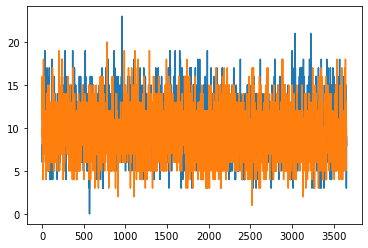

In [35]:
plt.plot(np.arange(1, len(nfarr)+1), nfarr)
plt.plot(np.arange(1, len(z_nfeatures)+1), z_nfeatures)

In [37]:
print(f"CONTROL: avg = {nfarr.mean().item()}, std = {nfarr.std().item()}")
print(f"LWOFF: avg = {z_nfeatures.mean().item()}, std = {z_nfeatures.std().item()}")

CONTROL: avg = 10.061866958664112, std = 2.869934298265324
LWOFF: avg = 9.287708732548591, std = 2.695750938798444


In [47]:
# very interesting --- we need to know whether the size of the features changes:
for i, f in enumerate(ipsl1_nfeatures):
    A = ipsl1_labels[i,:,:]
    for j in range(1,f+1):
        

<xarray.DataArray ()>
array(90)
Coordinates:
    time     object 1979-01-01 12:00:00

In [50]:
%%time
(ipsl1_labels[0,:,:] == 2).sum()

CPU times: user 1.76 ms, sys: 139 µs, total: 1.9 ms
Wall time: 13.1 ms


<xarray.DataArray ()>
array(1)

In [57]:
%%time
indices = np.where(ipsl1_labels.values[0,:,:] == 2)
len(indices[0])

CPU times: user 457 µs, sys: 263 µs, total: 720 µs
Wall time: 503 µs


1

In [67]:
%%time
ipsl1_size = []
ipsl1_sizestd = []
for i, tim in enumerate(ipsl1_labels['time']):
    ctr = np.bincount(ipsl1_labels[i,:,:].values.flatten())
    ipsl1_size.append(ctr[1::].mean())
    ipsl1_sizestd.append(ctr[1::].std())
ipsl1_size = np.array(ipsl1_size)
ipsl1_sizestd = np.array(ipsl1_sizestd)

CPU times: user 3.2 s, sys: 24.6 ms, total: 3.22 s
Wall time: 3.32 s


In [78]:
ipsl0_size.mean()

2.3724918827250585

In [64]:
generate_binary_structure(3,2)

array([[[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]])

In [20]:
np.unique?

Signature:
np.unique(
    ar,
    return_index=False,
    return_inverse=False,
    return_counts=False,
    axis=None,
)
Docstring:
Find the unique elements of an array.

Returns the sorted unique elements of an array. There are three optional
outputs in addition to the unique elements:

* the indices of the input array that give the unique values
* the indices of the unique array that reconstruct the input array
* the number of times each unique value comes up in the input array

Parameters
----------
ar : array_like
    Input array. Unless `axis` is specified, this will be flattened if it
    is not already 1-D.
return_index : bool, optional
    If True, also return the indices of `ar` (along the specified axis,
    if provided, or in the flattened array) that result in the unique array.
return_inverse : bool, optional
    If True, also return the indices of the unique array (for the specified
    axis, if provided) that can be used to reconstruct `ar`.
return_counts : bool, optiona

In [31]:
s = ipsl0_labels.shape
(ipsl0_labels.values.reshape((s[0], s[1]*s[2])), axis=1)

array([[ 0,  0,  0, ..., 22, 22, 22],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [32]:
np.unique(ipsl0_labels[0, :, :])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int32)

In [33]:
np.unique(ipsl0_labels[4, :, :])

array([ 0,  3,  4,  7,  8, 27, 33, 35, 41, 44, 50, 51, 52, 53, 54, 55, 56,
       57, 58], dtype=int32)

In [44]:
foo = (10, [1, 2, 3])
print(foo)
foo[0] = 15
print(foo)

(10, [1, 2, 3])


TypeError: 'tuple' object does not support item assignment